In [1]:
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import Audio
from tensorflow.python.ops import math_ops
from keras.layers import Dense, LSTM, Input, Add
from keras.models import load_model
from keras.optimizers import Adam
from keras.saving import register_keras_serializable
from keras import Model

from Utilities.DataProcessor import TimeDomain
from Utilities import LossFactory

print('Imported')

/var/folders/27/q7qn8b856fl5vzn7wn3sc19h0000gn/T/ipykernel_96357/787138370.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-24 22:51:24.539396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Imported


In [3]:
''' Pre process data '''

td = TimeDomain()
ip_shape, X_train = td.pre_process('X_train.wav')
ip_shape, Y_train = td.pre_process('Y_train.wav')
assert X_train.shape == Y_train.shape
print(ip_shape)

/var/folders/27/q7qn8b856fl5vzn7wn3sc19h0000gn/T/ipykernel_96357/1113829126.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, wavfile = read(join(DATA_DIR, filepath))


(52, 44100, 1)


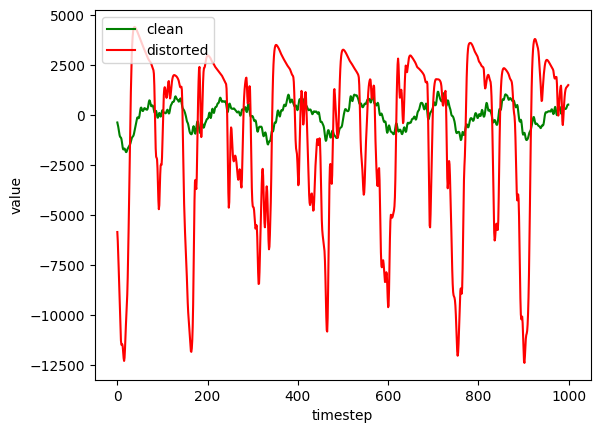

In [177]:
''' Plot X_train and Y_train ''' 

plt.plot(X_train[25][1000:2000], color='green')
plt.plot(Y_train[25][1000:2000], color='red')
plt.xlabel('timestep')
plt.ylabel('value')
plt.legend(['clean', 'distorted'], loc='upper left')
plt.show()

# Observation: Distorted signal closely follows clean closely
# but has high amplitude. Typical of Overdriven signal
# Also, Distorted seems to have lower troughs but marginally higher peaks, if any, when
# compared to clean signal

In [4]:
''' Define Custom Loss and register '''

# Serilizability is important for Keras to be able to read saved models
loss_fn = register_keras_serializable(LossFactory.manufacture(0.75))

Complete


In [5]:
''' LSTM Model of the music data '''

# Since we are predicting a value for every timestep, we set return_sequences=True
input = Input(shape=ip_shape)
mLSTM = LSTM(units=20, return_sequences=True)(input)
mDense = Dense(units=20, activation='linear')(input)
mSkip = Add()([mLSTM, mDense])

mSkip = Dense(units=1, activation='linear')(mSkip)
model = Model(input, mSkip)

adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam, loss=loss_fn)
model.summary()
#history = model.fit(X_train, Y_train, epochs=10, validation_split=0.3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 44100, 1)]           0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 44100, 20)            1760      ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 44100, 20)            40        ['input_1[0][0]']             
                                                                                                  
 add (Add)                   (None, 44100, 20)            0         ['lstm[0][0]',                
                                                                     'dense[0][0]']           

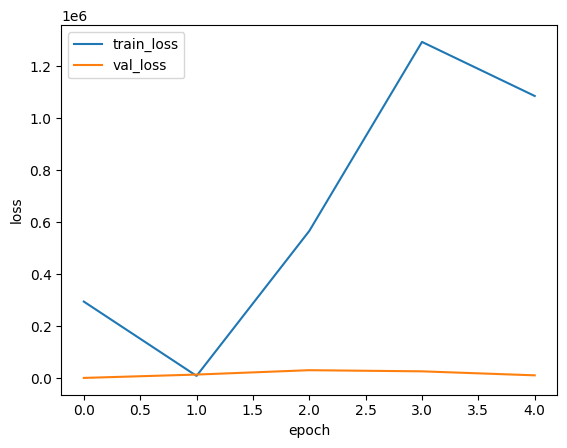

In [337]:
''' Plot train and val loss '''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [293]:
# Save model
model.save(join('Models', 'v1-lstm.keras'))

In [6]:
# Load the model
model = load_model(join('Models', 'v1-lstm.keras'))

In [21]:
# Distort the test sample
X_test = td.pre_process('X_test.wav')
Y_test = td.pre_process('Y_test.wav')

Y_pred = model.predict(X_test)
print(Y_pred.shape)

/var/folders/27/q7qn8b856fl5vzn7wn3sc19h0000gn/T/ipykernel_96357/1113829126.py:20: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, wavfile = read(join(DATA_DIR, filepath))


1/1 [==============================] - 2s 2s/step
(749700,)


In [22]:
# saving the LSTM predicitons in wav format
wavfile = td.post_process(Y_pred)
td.save('Y_pred.wav', wavfile)

Written


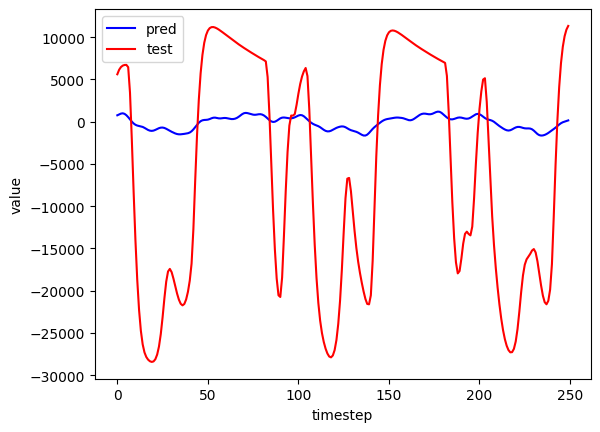

In [13]:
# Plot X_train and Y_train 
plt.plot(Y_pred[10][1000:1250], color='blue')
plt.plot(Y_test[10][1000:1250], color='red')
#plt.plot(X_test[10][1000:1250], color='green')
plt.xlabel('timestep')
plt.ylabel('value')
plt.legend(['pred', 'test', 'clean'], loc='upper left')
plt.show()

In [ ]:
# Play Predicted sample  
Audio(join(DATA_DIR, 'Y_pred.wav')) 